In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
import pickle

In [ ]:
pickle_images_features = open("images_features.pickle","rb")
images_features = pickle.load(pickle_images_features)

In [ ]:
pickle_images_captions = open("images_captions.pickle","rb")
images_captions = pickle.load(pickle_images_captions)

In [ ]:
import tensorflow

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN=36
vocab_size=8912
num_classes=vocab_size+1

In [ ]:
del images_captions['']

In [ ]:
X_features=[]
y_input=[]
y_output=[]

for key,value in images_captions.items():
  
  for caption_index in value:
    
    for i in range(1,len(caption_index)):
      
      X_features.append(images_features[key])
      input_caption=[caption_index[:i]]
      output_caption=caption_index[i]
      
      input_caption=pad_sequences(input_caption,maxlen=MAX_LEN,padding='post',truncating='post')[0]
      output_caption=to_categorical([output_caption],num_classes=num_classes)[0]
      
      y_input.append(input_caption)
      y_output.append(output_caption)


In [ ]:
len(X_features)

495303

In [ ]:
len(y_input)

495303

In [ ]:
len(y_output)

495303

In [ ]:
type(X_features)

list

In [ ]:
X_features=np.array(X_features)
y_input=np.array(y_input)
y_output=np.array(y_output)


In [ ]:
X_features.shape

(495303, 2048)

In [ ]:
y_input.shape

(495303, 36)

In [ ]:
y_output.shape

(495303, 8913)

In [ ]:
type(y_output)

numpy.ndarray

In [ ]:
type(y_input)

numpy.ndarray

In [ ]:
y_input.shape

(495303, 36)

In [ ]:
y_input

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  2,  0, ...,  0,  0,  0],
       [ 1,  2, 43, ...,  0,  0,  0],
       ...,
       [ 1, 48, 49, ...,  0,  0,  0],
       [ 1, 48, 49, ...,  0,  0,  0],
       [ 1, 48, 49, ...,  0,  0,  0]], dtype=int32)

In [ ]:
y_output

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Creating a Model

In [ ]:
import tensorflow

In [ ]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Input,LSTM,Dropout,Embedding,Flatten,Convolution2D,TimeDistributed,Bidirectional,RepeatVector,Concatenate,Activation
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
output_dims=128
MAX_LEN=36
vocab_size=8912
num_classes=vocab_size+1

# Creating a model for images
sub_model_img=Sequential()
sub_model_img.add(Dense(units=output_dims,input_shape=(2048,),activation='relu'))
sub_model_img.add(RepeatVector(MAX_LEN))

# Creating a model for caption input

sub_model_caption=Sequential()
sub_model_caption.add(Embedding(input_dim=vocab_size+1,output_dim=output_dims,input_length=MAX_LEN))
sub_model_caption.add(LSTM(units=256,return_sequences=True))
sub_model_caption.add(TimeDistributed(Dense(units=output_dims)))

model_concatenation=Concatenate()([sub_model_img.output,sub_model_caption.output])
final_model=LSTM(units=256,return_sequences=True)(model_concatenation)
final_model=LSTM(units=512,return_sequences=False)(final_model)
final_model=Dense(units=num_classes)(final_model)
output=Activation('softmax')(final_model)

model=Model(inputs=[sub_model_img.input,sub_model_caption.input],outputs=output)


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 36)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 128)      1140864     embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
_______________________________________________________________________________________

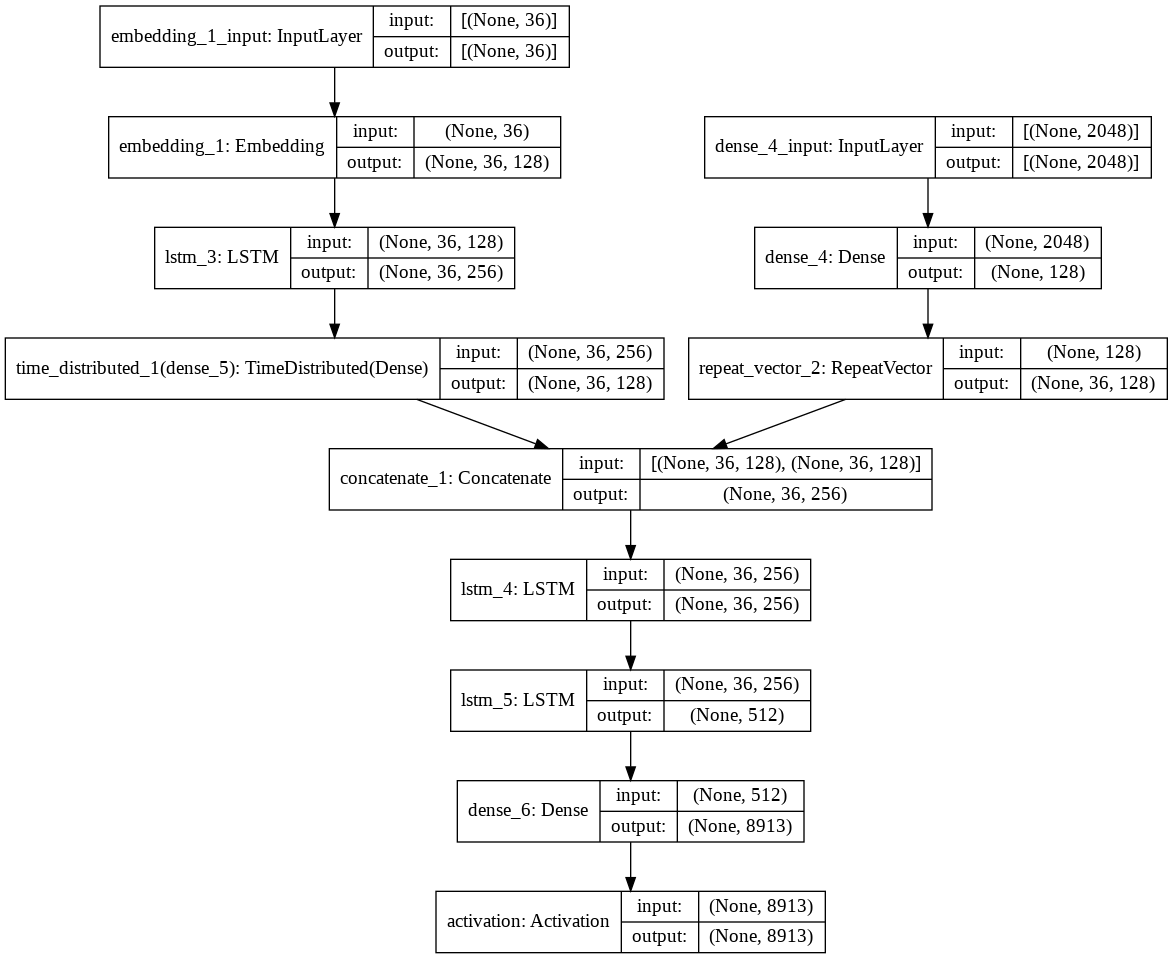

In [ ]:
tensorflow.keras.utils.plot_model(model, show_layer_names=True,show_shapes=True)

In [ ]:
model.fit([X_features,y_input],y_output,batch_size=512,epochs=30)

Epoch 1/30
968/968 [==============================] - 1111s 1s/step - loss: 4.7900 - accuracy: 0.1894
Epoch 2/30
968/968 [==============================] - 1111s 1s/step - loss: 4.0427 - accuracy: 0.2958
Epoch 3/30
968/968 [==============================] - 1115s 1s/step - loss: 3.4709 - accuracy: 0.3637
Epoch 4/30
968/968 [==============================] - 1136s 1s/step - loss: 3.1870 - accuracy: 0.3970
Epoch 5/30
968/968 [==============================] - 1119s 1s/step - loss: 3.0366 - accuracy: 0.4156
Epoch 6/30
968/968 [==============================] - 1120s 1s/step - loss: 2.9301 - accuracy: 0.4299
Epoch 7/30
968/968 [==============================] - 1137s 1s/step - loss: 2.8485 - accuracy: 0.4422
Epoch 8/30
968/968 [==============================] - 1119s 1s/step - loss: 2.7780 - accuracy: 0.4517
Epoch 9/30
968/968 [==============================] - 1119s 1s/step - loss: 2.7198 - accuracy: 0.4613
Epoch 10/30
968/968 [==============================] - 1120s 1s/step - loss: 2.664

In [ ]:
model.save_weights("model_weights.h5")

In [ ]:
model.save("model.h5")

In [ ]:
!gsutil cp 'model.h5' gs://aditya_1

Copying file://model.h5 [Content-Type=application/octet-stream]...
\ [1 files][ 64.9 MiB/ 64.9 MiB]                                                
Operation completed over 1 objects/64.9 MiB.                                     


In [ ]:
!gsutil cp 'model_weights.h5' gs://aditya_1

Copying file://model_weights.h5 [Content-Type=application/octet-stream]...
| [1 files][ 32.5 MiB/ 32.5 MiB]                                                
Operation completed over 1 objects/32.5 MiB.                                     
